In [76]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from tqdm import tqdm

# A/B testing
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

**Тестовая группа (a):**<br/>
Всего пользователей - 202667<br/>
Кол-во платящих пользователей - 1805

**Контрольная группа (b):**<br/>
Всего пользователей - 202103<br/>
Кол-во платящих пользователей - 1928

#### Метрики:
Для принятия решения проанализируем метрики качества: ARPU, ARPPU, доля платящих и конверсия в платеж.
Метрика количества Revenue не подойдет, так как она является лишь следствием качественного изменения

In [110]:
abtest = pd.read_csv(file)

Структура таблицы:<br/>
- user_id: уникальный номер пользователя
- revenue: прибыль (сумма, которую потратил пользователь)
- testgroup: группа пользователя, a - тестовая, b - контрольная

In [111]:
abtest.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


#### Проверка таблицы на пропущенные значения, дубликаты, распределение пользователей между группами, на корректность данных

In [112]:
abtest.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [113]:
abtest.user_id.duplicated().sum()

0

In [114]:
abtest.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [115]:
ab_pie = abtest.groupby('testgroup', as_index=False).count()

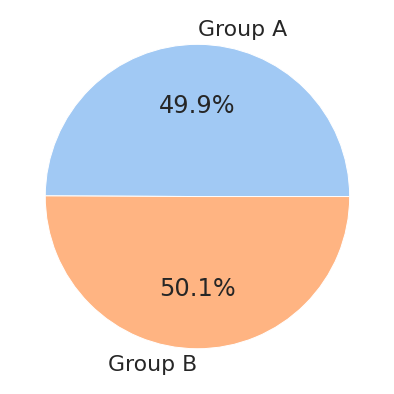

In [116]:
#Рассмотрим распределение количества пользователей в группах. По размеру группы примерно одинаковые (49,9%:50,1%)
colors = sns.color_palette('pastel')[0:2]
labels = ['Group A', 'Group B']
plt.pie(ab_pie.revenue , labels=labels, colors = colors, autopct='%.1f%%')
plt.show()

#### Выводы
- по количеству пользователей группы распределены равномерно (50% / 50%)
- пропущенных значений и дубликатов нет
- ошибок в даных выручки нет (все данный от 0 и выше, нет минусовых значений)

### Посмотрим детально отдельно группы А и В

Посмотрим на распределение доходов от платящих пользователей с разбивкой на группы

In [117]:
abtest_rev = abtest.query("revenue > 0").sort_values('revenue', ascending=False)

Text(0.5, 1.0, 'Доход от платящих пользователей с разбивкой по группам')

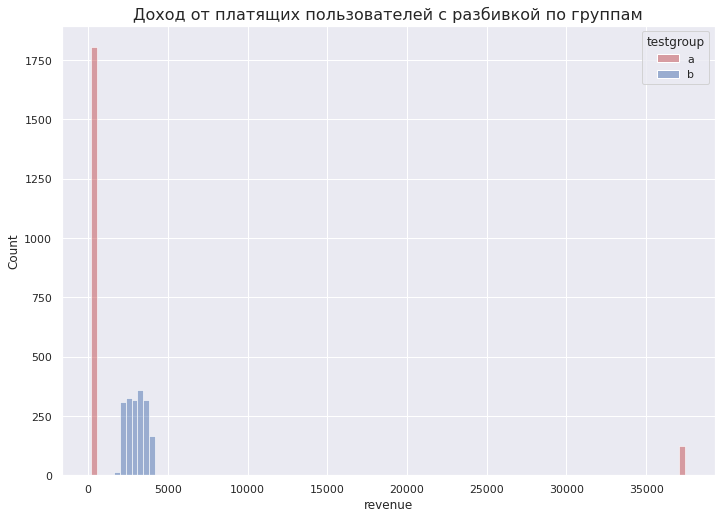

In [118]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = abtest_rev, 
              x='revenue', 
              hue='testgroup', 
              palette = ['r', 'b'],
              kde=False)
plt.title("Доход от платящих пользователей с разбивкой по группам", fontsize=16, ha='center')

Рассмотрим каждую группу по отдельности, а также посчитаем ARPU, ARPPU и конверсию

ARPU (Average revenue per user) <br/>
**ARPU**=Конверсия⋅ARPPU<br/>


**Конверсия** = Число клиентов/Число пользователей <br/>
**ARPPU** = Число клиентов/Доход

### Рассмотрим детально группы А и В

In [119]:
abtest_a = abtest.query("testgroup == 'a'")

In [120]:
abtest_b = abtest.query("testgroup == 'b'")

Из графика выше мы видим, что в распределении revenue есть аномально высокие значения. Так, есть часть пользователей с покупкаме выше 35 тысяч. Либо это связано с каими-либо ошибками логирования, либо в тестовую группу попали киты. Если это так, то для дальнейшего анализа AB теста необходимо избавиться от данных выбросов. Для начала посмотрим, какую часть от всех пользователей они составляют

In [121]:
print ('Клиентов с покупами свыше 35 тыс', round(abtest_a.query("revenue>35000").shape[0]/abtest_a.shape[0]*100,2), '%')

Клиентов с покупами свыше 35 тыс 0.06 %


Проверим распределение пользователей в группах, если из группы А уберем данные выбросы

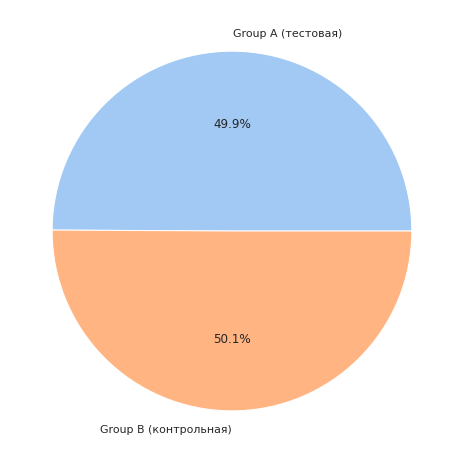

In [122]:
ab_pie_corr = abtest.query("revenue<35000").groupby('testgroup', as_index=False).count()
colors = sns.color_palette('pastel')[0:2]
labels = ['Group A (тестовая)', 'Group B (контрольная)']
plt.pie(ab_pie_corr.revenue , labels=labels, colors = colors, autopct='%.1f%%')
plt.show()
#распределение пользователей в группах по численности не изменилось

In [123]:
abtest_a = abtest_a.query("revenue < 35000") #убираем выбросы
abtest = abtest.query("revenue < 35000")

In [124]:
abtest_a_CR = round((abtest_a.query("revenue > 0").shape[0]/abtest_a.shape[0] * 100), 3)
abtest_a_ARPPU = round(abtest_a.revenue.sum()/abtest_a.query("revenue > 0").shape[0],2)
abtest_a_ARPU = round(abtest_a_CR*abtest_a_ARPPU,2)

abtest_b_CR = round((abtest_b.query("revenue > 0").shape[0]/abtest_b.shape[0] * 100), 3)
abtest_b_ARPPU = round(abtest_b.revenue.sum()/abtest_b.query("revenue > 0").shape[0],2)
abtest_b_ARPU = round(abtest_b_CR*abtest_b_ARPPU,2)

In [125]:
print('Размер группы A :',abtest_a.shape[0], 'пользователей / группы B :', abtest_b.shape[0])
print('Конверсия в тестовой группе А :',abtest_a_CR, '/ в контрольной группе B :', abtest_b_CR)
print('ARPPU в тестовой группе А =', abtest_a_ARPPU, '/ в контрольной группе B :',abtest_b_ARPPU)
print('ARPU в тестовой группе А =', abtest_a_ARPU, '/ в контрольной группе B :',abtest_b_ARPU)
print('Median Revenue per User в тестовой группе A (платящие) = ',abtest_a.query('revenue > 0').revenue.median().round(2),'/ в контрольной группе B :',abtest_b.query('revenue > 0').revenue.median().round(2))

Размер группы A : 201980 пользователей / группы B : 202667
Конверсия в тестовой группе А : 0.894 / в контрольной группе B : 0.891
ARPPU в тестовой группе А = 302.46 / в контрольной группе B : 3003.66
ARPU в тестовой группе А = 270.4 / в контрольной группе B : 2676.26
Median Revenue per User в тестовой группе A (платящие) =  305.0 / в контрольной группе B : 3022.0


После удаления выбросов, видим, что конверсия на одном уровне, а ARPU, ARPPU и медианный доход от пользователя в группе B выше почти в 10 раз

Посмотрим на распредение доходов от платящих пользователей после удаления выбросов

Text(0.5, 1.0, 'Доход от платящих пользователей с разбивкой по группам')

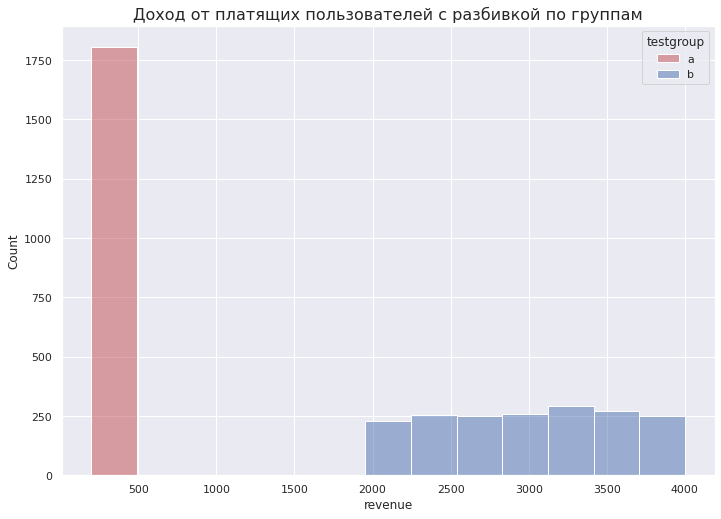

In [126]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = abtest.query("revenue>0 & revenue<35000"), 
              x='revenue', 
              hue='testgroup', 
              palette = ['r', 'b'],
              kde=False)
plt.title("Доход от платящих пользователей с разбивкой по группам", fontsize=16, ha='center')

In [127]:
abtest_a_pay = abtest_a.query("revenue > 0")
abtest_b_rev = abtest_b.query("revenue > 0")

Text(0.5, 1.0, 'Доход от платящих пользователей в контрольной группе В')

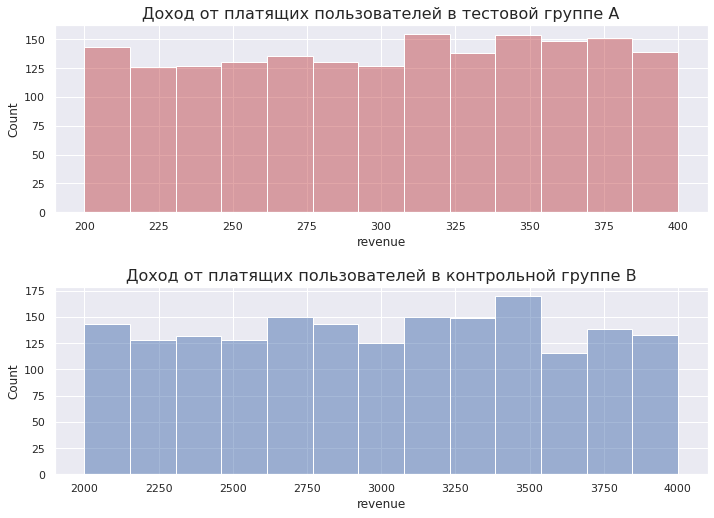

In [128]:
fig, axes = plt.subplots(nrows=2, ncols=1)

ax1 = plt.subplot(2, 1, 1)
sns.histplot(data = abtest_a_pay, x='revenue', 
              color = ['r'],
              alpha=0.5,
              kde=False)
plt.title("Доход от платящих пользователей в тестовой группе А", fontsize=16, ha='center')
plt.subplots_adjust(hspace = .4)

ax1 = plt.subplot(2, 1, 2)
sns.histplot(data = abtest_b_rev, x='revenue', 
              color = ['b'],
              alpha=0.5,
              kde=False)
plt.title("Доход от платящих пользователей в контрольной группе В", fontsize=16, ha='center')

### Проверка на нормальность

Для проверки на нормальность используем тест Шапиро-Уилка 

In [129]:
result = stats.shapiro(abtest[abtest['testgroup'] == 'a'].revenue.sample(1000, random_state=17))
alpha = 0.05

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение в тестовой группе А является нормальным')
else:
    print('Распределение в тестовой группе А не является нормальным')

test statistic = 0.0930, pvalue = 0.0000e+00
Распределение в тестовой группе А не является нормальным


In [130]:
result = stats.shapiro(abtest[abtest['testgroup'] == 'a'].revenue.sample(1000, random_state=17))
alpha = 0.05

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение в контрольной группе B является нормальным')
else:
    print('Распределение в контрольной группе B не является нормальным')

test statistic = 0.0930, pvalue = 0.0000e+00
Распределение в контрольной группе B не является нормальным


### Проверка на гомогенность дисперсии

Для проверки выборок на гомогенность дисперсии проведем тест Левена

In [131]:
alpha = 0.05  

lv = stats.levene(abtest[abtest['testgroup'] == 'a'].revenue, 
               abtest[abtest['testgroup'] == 'b'].revenue)
if lv.pvalue > alpha:
    param = True
    print('Выборки тестовой и контрольной группы имеют схожие дисперсии')
else:
    print('Дисперсии выборок тестовой и контрольной группы различны')
    param = False

Дисперсии выборок тестовой и контрольной группы различны


### Вывод
Данные выборки не имеют нормальное распределение, а также они не прошли тест на гомогенность дисперсии. Для выявления статистической значимости будем использовать критерий Манна-Уитни о равенстве распределений

#### Гипотеза
Нулевая гипотеза Н0 : распределение значений выручки с пользователя контрольной и тестовой групп не различаются <br/>
Альтернативная гипотеза Н1 : распределение значений выручки с пользователя контрольной и тестовой групп различны

In [132]:
alpha = 0.05

result_Mann_Wh= stats.mannwhitneyu(abtest[abtest.testgroup == 'a'].revenue, 
                   abtest[abtest.testgroup == 'b'].revenue,
                   alternative = 'two-sided')
print('Mann–Whitney U test statistic = {:.4f}, pvalue = {:.4e}'.format(result_Mann_Wh[0], result_Mann_Wh[1]))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, распределения в двух выборках не равны')
else:
    print('У нас не достаточно оснований, чтобы отвергнуть нулевую гипотезу и принять альтернативную')

Mann–Whitney U test statistic = 20466331335.0000, pvalue = 8.6757e-01
Отвергаем нулевую гипотезу, распределения в двух выборках не равны


**Для принятия решений будем опираться на 3 метрики: конверсия, ARPPU, ARPPU**

### Анализ конверсии в покупку

In [133]:
#добавим колонку конверсии в покупку: 0 - пользователь не совершал покупки, 1 - пользователь совершал покупки
abtest['CR'] = abtest['revenue'].apply(lambda x: 0 if x == 0 else 1)

In [134]:
print('Конверсия в тестовой группе А :',abtest_a_CR, '/ в контрольной группе B :', abtest_b_CR)

Конверсия в тестовой группе А : 0.894 / в контрольной группе B : 0.891


In [135]:
def get_bootstrap(data_column_1, data_column_2, boot_it = 1000,
    statistic = np.mean, bootstrap_conf_level = 0.95):
    
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.rcParams['figure.figsize'] = (12,8);
    plt.show()
       
    return {'boot_data': boot_data, 
            'quants': quants, 
            'p_value': p_value}

100%|██████████| 1000/1000 [00:22<00:00, 44.37it/s]


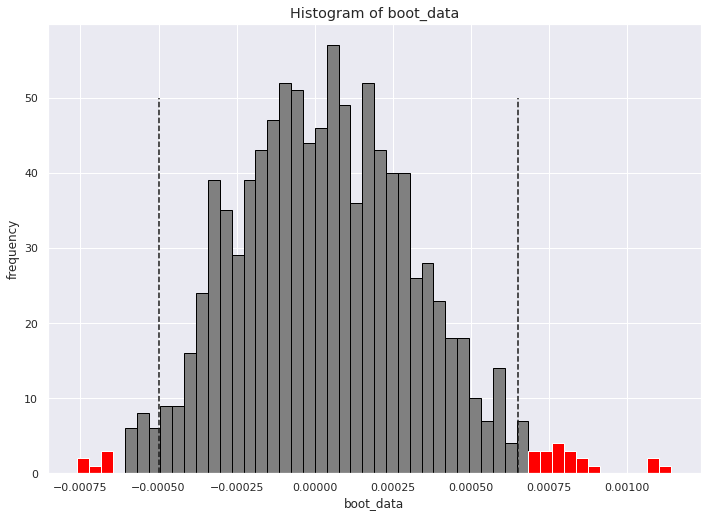

In [136]:
CR = get_bootstrap(abtest[abtest['testgroup'] == 'a'].CR,
                    abtest[abtest['testgroup'] == 'b'].CR,
                    statistic=np.mean)

Доверительный интервал попадает в 0, гистограмма не прокрасилась, то есть в случае с конверсией не победил ни один вариант

### Анализ средней выручки на одного пользователя ARPU

100%|██████████| 1000/1000 [00:24<00:00, 41.02it/s]


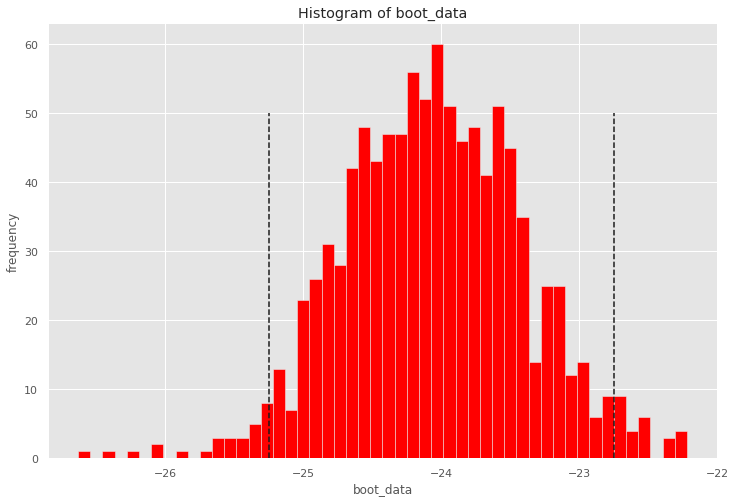

In [137]:
ARPU = get_bootstrap(abtest[abtest['testgroup'] == 'a'].revenue,
                    abtest[abtest['testgroup'] == 'b'].revenue,
                    statistic=np.mean)

Доверительный интервал не попадает в ноль, гистограмма "прокрасилась", что дает нам право отвергнуть нулевую гипотезу, что ARPU в тестовой и контрольной группах не различаются

### Анализ средней выручки на одного платящего пользователя ARPPU

100%|██████████| 1000/1000 [00:00<00:00, 2387.31it/s]


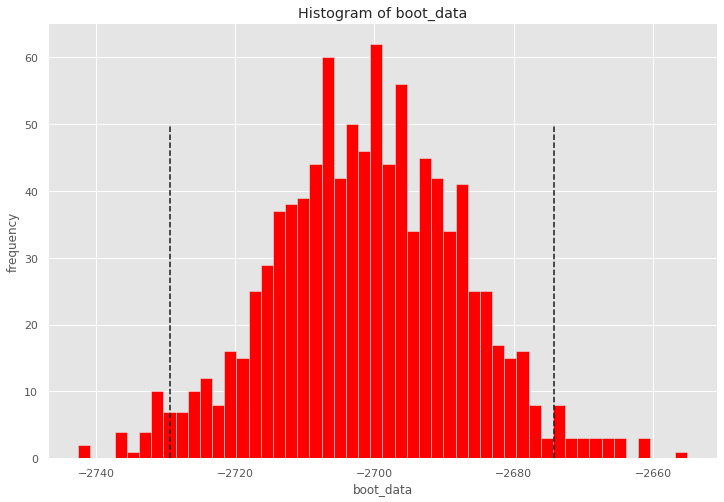

In [138]:
ARPPU = get_bootstrap(abtest[(abtest['testgroup'] == 'a') & (abtest['revenue'] > 0)].revenue,
                          abtest[(abtest['testgroup'] == 'b') & (abtest['revenue'] > 0)].revenue,
                          statistic=np.mean)

Доверительный интервал не попадает в ноль, гистограмма "прокрасилась", что дает нам право отвергнуть нулевую гипотезу, что ARPU в тестовой и контрольной группах не различаются

## Вывод

С помощью критерия Шапиро-Уилка выборки были проверены на нормальность и с помощью теста Левена на гомогенность дисперсии. Распределение в обеих группах не является нормальным и дисперсии в выборках не являются гомогенными <br/>
Для начала был проведен тест Манна-Уитни, в результате которого был сделан вывод, что распределение в обеих группах не равны <br/>
Для принятия решения были проанализированы с помощью бутстрапа 3 метрики: конверсия, ARPU и ARPPU <br/>
Статистически значимых различий в конверсии обнаружено не было, анализ ARPU и ARPPU статистически значимые различия показал <br/>
**Таким образом, принято решение выкатывать набор акционных предложений контрольной группы B**

Метрики останутся такими же. Особенно интересно сравнить усложненную механику с облегченный по Retention (как отдельно тематического события, так и игры в целом), так как пользователи могут получить негативные эмоции, откатываясь назад, и перестать в целом играть в игру